In [2]:
# Setup Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Global imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Typing import
from typing import List, Dict, Union, Tuple

# Specific imports
from copy import deepcopy
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.animation import FuncAnimation, PillowWriter
from rich import print
from termcolor import cprint

# Local imports
from loading import csv_to_dict

sns.set_theme('notebook')
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

def print_bl():
    print("\n")


def print_red(*args):
    for arg in args:
        cprint(arg, "red", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_green(*args):
    for arg in args:
        cprint(arg, "green", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_highlight(*args):
    for arg in args:
        cprint(arg, "magenta", "on_white", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_blue(*args):
    for arg in args:
        cprint(arg, "light_blue", end=' ')  # Using end=' ' to print all arguments on the same line
    print()


Group definition:
- 1 second sampling rate.
- In any scene, choose an ego vehicle __outside__ of the roundabout. That is the ego vehicle.
    - Sample the database until the ego vehicle enters the roundabout
    - If window length is short, resample the same scene with another ego_vehicle. If there are not any suitable vehicles, move on.
- Max window length: 5 seconds.

Refer all coordinates to the center of the roundabout. Perform calculations in pixels and then convert to meters using OrthoPxToMeter*10.

In [24]:
class RounDGroupExtractor:
    """
    A class that extracts vehicle groups from a rounD dataset recording, specifically focusing on 
    vehicles entering and navigating through a roundabout.

    Attributes:
        dataset_location (str): Path to the directory where the dataset is stored.
        dataset_index (int): Index of the recording to be processed (must be between 1 and 22).
        data (pd.DataFrame): Raw vehicle trajectory data from the recording.
        static_info (pd.DataFrame): Static information about the vehicles.
        video_info (dict): Metadata about the video recording, including frame rate and scaling factor.
        sampling_period (int): Time interval between frames to include in the analysis.
        frame_spacing (int): Number of frames between each sampled frame.
        frame_length (float): Duration of each frame in milliseconds.
        framing_dict (Dict[int, int]): Dictionary mapping new frame numbers to original frame numbers.
        raw_frames (pd.Series): Original frame numbers before filtering.
        bg_image (np.ndarray): Background image for plotting and analysis.
        bg_image_scaling_factor (float): Scaling factor for converting pixel coordinates to meters.
        center_x_px (int): X-coordinate of the roundabout center in pixels.
        center_y_px (int): Y-coordinate of the roundabout center in pixels.
        outer_radius_px (int): Radius of the outer edge of the roundabout in pixels.
        inner_radius_px (int): Radius of the inner edge of the roundabout in pixels.
        center_x_m (float): X-coordinate of the roundabout center in meters.
        center_y_m (float): Y-coordinate of the roundabout center in meters.
        outer_radius_m (float): Radius of the outer edge of the roundabout in meters.
        inner_radius_m (float): Radius of the inner edge of the roundabout in meters.
        entry_points_px (Dict[str, Tuple[int, int]]): Entry points of the roundabout in pixels.
        exit_points_px (Dict[str, Tuple[int, int]]): Exit points of the roundabout in pixels.
        entry_points_m (Dict[str, Tuple[float, float]]): Entry points of the roundabout in meters.
        exit_points_m (Dict[str, Tuple[float, float]]): Exit points of the roundabout in meters.
        rotation_angle (float): Angle of rotation for aligning the roundabout arms with the x-axis.
        entry_points_m_new (Dict[str, Tuple[float, float]]): Translated and rotated entry points in meters.
        exit_points_m_new (Dict[str, Tuple[float, float]]): Translated and rotated exit points in meters.
        
    Methods:
        get_background_img(path): Loads the background image for plotting and geometry calculations.
        get_roundabout_edges(): Detects the roundabout's center and the radii of the inner and outer edges.
        get_entry_exit_points(): Calculates the roundabout’s entry and exit points using homography.
        plot_roundabout_geometry_and_points(rotate): Plots the roundabout geometry and optionally rotates it.
        in_roundabout(x, y): Checks if a given point (x, y) is within the roundabout's boundaries.
        filter_data(sampling_period): Filters the dataset based on a specified sampling period.
        translate(): Translates and rotates vehicle positions to align the roundabout with the x-axis.
        get_ego_vehicles(entry_radius): Identifies vehicles entering the roundabout and logs their entry frame and point.
    """
    def __init__(self, dataset_location: str = None, dataset_index: int = None) -> None:
        """
        Initializes the RounDGroupExtractor class for processing a specific dataset recording.

        This constructor sets up the necessary attributes for analyzing vehicle trajectories around a roundabout. 
        It loads the dataset's raw data, static vehicle information, and video metadata, and prepares the background 
        image for plotting and geometric calculations. The roundabout's center, inner/outer radii, and entry/exit points 
        are also initialized, and homography is applied to align the current image with reference data.

        Args:
            dataset_location (str): The path to the directory where the dataset is stored.
            dataset_index (int): The index of the recording to process (must be between 1 and 22).

        Raises:
            ValueError: If no dataset location is provided or if the dataset index is outside the valid range.
        """
        ### Error handling
        if dataset_location is None:
            raise ValueError("Please provide a dataset location.")
        if dataset_index is None or dataset_index < 1 or dataset_index > 22:
            raise ValueError("Please provide a dataset index between 1 and 22")
        
        # Reference points for homography
        self.reference_exit_points = {'north': (961,238), 'south': (645, 695), 'east': (1053, 590), 'west': (550, 354)}
        self.reference_entry_points = {'north': (880, 195), 'south': (724, 735), 'east': (1083, 503), 'west': (528, 439)}
        self.reference_rotation_angle = 14.25

        # Entry and exit points for the current image - Initialized in get_entry_exit_points
        self.entry_points = {}
        self.exit_points = {}
        self.rotation_angle = 0.0

        # retrieve raw data
        self.dataset_index  = dataset_index
        self.dataset_location = dataset_location
        self.df_location = dataset_location + str(dataset_index).zfill(2) + "_tracks.csv"
        self.static_info_location = dataset_location + str(dataset_index).zfill(2) + "_tracksMeta.csv"
        self.video_info_location = dataset_location + str(dataset_index).zfill(2) + "_recordingMeta.csv"
        self.reference_image_path = dataset_location + '00_background.png'
        self.image_path = dataset_location + f'{str(dataset_index).zfill(2)}_background.png'

        self.data = pd.read_csv(self.df_location)
        self.raw_data = deepcopy(self.data)
        self.static_info = pd.read_csv(self.static_info_location)
        self.video_info = csv_to_dict(self.video_info_location)

        self.frame_length = 1000/self.video_info["frameRate"] # Measured in miliseconds

        # get dictionary with keys as trackId and values as class
        self.vehicle_type = dict(zip(self.static_info.trackId, self.static_info['class']))
        self.restricted_vehicle_types = ['pedestrian', 'bicycle']

        self.get_background_img(self.image_path)
        self.center_x_px, self.center_y_px, self.outer_radius_px, self.inner_radius_px = self.get_roundabout_edges()
        self.entry_points_px, self.exit_points_px = self.get_entry_exit_points()

        # Convert pixel values to meters
        self.center_x_m = self.center_x_px * self.bg_image_scaling_factor
        self.center_y_m = -self.center_y_px * self.bg_image_scaling_factor
        self.outer_radius_m = self.outer_radius_px * self.bg_image_scaling_factor
        self.inner_radius_m = self.inner_radius_px * self.bg_image_scaling_factor
        self.entry_points_m = {key: (point[0] * self.bg_image_scaling_factor, -point[1] * self.bg_image_scaling_factor) for key, point in self.entry_points_px.items()}
        self.exit_points_m = {key: (point[0] * self.bg_image_scaling_factor, -point[1] * self.bg_image_scaling_factor) for key, point in self.exit_points_px.items()}

        self.ego_vehicles = {}
 
    def get_background_img(self, path) -> None:
        """
        Loads the background image for plotting and analysis.

        Args:
            path (str): Path to the PNG image file containing the background image.

        Raises:
            FileNotFoundError: If the background image is not found at the specified path.

        Initializes the image scaling factor (meters per pixel) using data from the video information. 
        From experimentation, this factor needs to be multiplied by 10 to match the roundabout geometry.
        """
        ### Error handling
        if not os.path.exists(path):
            raise FileNotFoundError(f"Background image not found at {path}.")
        self.bg_image = cv2.imread(path)
        self.bg_image_scaling_factor = self.video_info["orthoPxToMeter"]*10 # Measured in meters per pixel

    def get_roundabout_edges(self) -> Tuple[int, int, int, int]:
        """
        Detects the outer and inner edges of the roundabout using HoughCircles.

        Returns:
            Tuple[int, int, int, int]: A tuple containing the X and Y coordinates of the roundabout center, 
            and the radii of the outer and inner circles, respectively.

        Raises:
            ValueError: If no outer or inner edge is detected.
        """

        gray = cv2.cvtColor(self.bg_image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 7), 0)

        # Use HoughCircles to detect the roundabout's outer edge
        outer_circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=1000,
            param1=100, param2=30, minRadius=200, maxRadius=300
        )

        if outer_circles is not None:
            outer_circles = np.round(outer_circles[0, :]).astype("int")
            largest_circle = max(outer_circles, key=lambda x: x[2])  # Select the largest circle (outer edge)
            center_x, center_y, outer_radius = largest_circle

            # Detect inner edge using a smaller radius range
            inner_circles = cv2.HoughCircles(
                blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=300,
                param1=100, param2=30, minRadius=100, maxRadius=outer_radius - 50
            )

            if inner_circles is not None:
                inner_circles = np.round(inner_circles[0, :]).astype("int")
                inner_center_x, inner_center_y, inner_radius = min(inner_circles, key=lambda x: abs(x[0] - center_x))
                return center_x, center_y, outer_radius, inner_radius

        raise ValueError("No outer or inner edge detected.")

    def get_entry_exit_points(self) -> Tuple[Dict[str, Tuple[int, int]], Dict[str, Tuple[int, int]]]:
        """
        Calculates the entry and exit points of the roundabout based on homography transformations.

        Returns:
            Tuple[Dict[str, Tuple[int, int]], Dict[str, Tuple[int, int]]]: Two dictionaries containing the 
            entry and exit points for the roundabout, where each key is the name of an entry/exit point 
            ('north', 'south', 'east', 'west') and each value is a tuple of pixel coordinates.
        """
        reference_image = cv2.imread(self.reference_image_path)
        current_image = cv2.imread(self.image_path)

        gray_reference = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)
        gray_current = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)

        # Feature matching with SIFT
        sift = cv2.SIFT_create()
        kp_ref, des_ref = sift.detectAndCompute(gray_reference, None)
        kp_cur, des_cur = sift.detectAndCompute(gray_current, None)

        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(des_ref, des_cur)
        matches = sorted(matches, key=lambda x: x.distance)

        ref_pts = np.float32([kp_ref[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        cur_pts = np.float32([kp_cur[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        # Compute homography matrix
        H, _ = cv2.findHomography(ref_pts, cur_pts, cv2.RANSAC, 5.0)

        self.rotation_angle = np.atan2(H[0, 1], H[0, 0]) * 180 / np.pi + self.reference_rotation_angle

        reference_entry_points = np.float32(list(self.reference_entry_points.values())).reshape(-1, 1, 2)
        reference_exit_points = np.float32(list(self.reference_exit_points.values())).reshape(-1, 1, 2)

        transformed_entry_points = cv2.perspectiveTransform(reference_entry_points, H)
        transformed_exit_points = cv2.perspectiveTransform(reference_exit_points, H)

        entry_points = {key: tuple(point[0]) for key, point in zip(self.reference_entry_points.keys(), transformed_entry_points)}
        exit_points = {key: tuple(point[0]) for key, point in zip(self.reference_exit_points.keys(), transformed_exit_points)}

        return entry_points, exit_points

    def plot_roundabout_geometry_and_points(self, rotate: bool = False) -> None:
        """
        Plots the roundabout geometry, including the inner and outer edges, and marks the entry/exit points.

        Args:
            rotate (bool): If True, rotates the image to align the roundabout arms with the x-axis.

        This method displays the background image with overlaid roundabout geometry, including the center, 
        inner and outer edges, and entry/exit points. Entry points are marked in red and exit points in blue.
        """
        ## Error handling
        if not hasattr(self, "center_x_px"):
            raise ValueError("Please call the get_roundabout_edges method first.")
        if not hasattr(self, "entry_points_px"):
            raise ValueError("Please call the get_entry_exit_points method first.")

        # Draw final roundabout geometry and entry/exit points
        plt.figure(figsize=(10, 8))
        result_image = self.bg_image.copy()
        cv2.circle(result_image, (self.center_x_px, self.center_y_px), self.outer_radius_px, (0, 255, 0), 4)  # Outer circle
        cv2.circle(result_image, (self.center_x_px, self.center_y_px), self.inner_radius_px, (255, 0, 0), 4)  # Inner circle
        cv2.circle(result_image, (self.center_x_px, self.center_y_px), 5, (0, 0, 255), -1)  # Center point

        # Mark entry and exit points
        for point in self.exit_points_px.values():
            cv2.circle(result_image, tuple(np.int32(point)), 10, (255, 0, 0), -1)  # Red for entry points - colors in BGR format
        for point in self.entry_points_px.values():
            cv2.circle(result_image, tuple(np.int32(point)), 10, (0, 0, 255), -1)  # Blue for exit points - colors in BGR format

        # Rotate the image if specified
        if rotate:
            w,h = result_image.shape[1], result_image.shape[0]
            M = cv2.getRotationMatrix2D((w/2,h/2), self.rotation_angle, 1)
            result_image = cv2.warpAffine(result_image, M, (w,h))
            
        # Display the final image with the geometry and points
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title("Roundabout Geometry with Entry (Red) and Exit (Blue) Points")
        plt.axis('off')
        plt.show()
    
    def in_roundabout(self, x: float, y: float) -> bool:
        """
        Checks if a point is inside the roundabout.
        
        Args:
            x (float): X-coordinate of the point.
            y (float): Y-coordinate of the point.
        
        Returns:
            bool: True if the point is inside the outer radius and outside the inner radius, False otherwise.
        """
        distance_to_center = np.linalg.norm(np.array([x, y]) - np.array([self.center_x_m, self.center_y_m]))
        return self.inner_radius_m <= distance_to_center <= self.outer_radius_m
    
    def filter_data(self, sampling_period: int = 1000) -> pd.DataFrame:
        """
        Filters the dataset based on a specified sampling period.
        Translates and rotates the data to align the roundabout arms with the x-axis.

        Args:
            sampling_period (int): The time interval between frames to include, in milliseconds.

        Returns:
            pd.DataFrame: A DataFrame containing only the frames that match the sampling period.

        Raises:
            ValueError: If the sampling period is not a multiple of the frame duration (40 ms).

        This method adjusts the frame numbering and generates a dictionary to map new frame numbers 
        to their original values. The resulting DataFrame only contains frames spaced according to the 
        specified sampling period.
        """
        ### Argument validation
        if sampling_period % self.frame_length != 0:
            raise ValueError("Sampling period must be a multiple of 40ms.")
        
        self.sampling_period = sampling_period
        self.frame_spacing = int(self.sampling_period / self.frame_length) #Frames are 40 ms apart

        ### Printing parameters
        print("Filtering data with the following parameters:")
        print_green(f"Sampling period: {self.sampling_period} ms")
        print_green(f"Frame spacing: {self.frame_spacing} frames")

        ### Start framing scheme from 0
        self.data['frame'] = self.data['frame'] - self.data['frame'].min()
        self.data = self.data[self.data.frame % self.frame_spacing == 0]
        self.raw_frames = deepcopy(self.data.frame) # copy the old frame numbering for animation purposes
        self.data.frame = self.data.frame / self.frame_spacing
        self.framing_dict = dict(zip(self.data.frame, self.raw_frames)) # create a dictionary to convert old frame numbering to new frame numbering

        # Transform coordinate system
        self.translate()
        return self.data
    
    def translate(self) -> None:
        """
        Translates the data to the center of the roundabout and performs a rotation to align the arms of the roundabout with the x-axis.

        Adds new columns to the dataframe for the translated and rotated coordinates. Updates the entry and exit points as well.
        """
        ### Error handling
        if not hasattr(self, "center_x_m"):
            raise ValueError("Please call the get_roundabout_edges method first.")
        if not hasattr(self, "framing_dict"):
            raise ValueError("Please filter the data first.")

        # Translate the data to the center of the roundabout
        self.data['xCenter_new'] = self.data['xCenter'] - self.center_x_m
        self.data['yCenter_new'] = self.data['yCenter'] - self.center_y_m

        # Rotate the data
        angle = np.radians(self.rotation_angle)
        print(f"Rotating data {self.rotation_angle:.2f} degrees counterclockwise to align the roundabout arms with the x-axis.")
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], 
                                    [np.sin(angle), np.cos(angle)]])
        self.data['xCenter_new'], self.data['yCenter_new'] = np.dot(rotation_matrix, [self.data['xCenter_new'], self.data['yCenter_new']])

        # Update the entry and exit points
        self.entry_points_m_new = {key: (point[0] - self.center_x_m, point[1] - self.center_y_m) for key, point in self.entry_points_m.items()}
        self.exit_points_m_new = {key: (point[0] - self.center_x_m, point[1] - self.center_y_m) for key, point in self.exit_points_m.items()}
        self.entry_points_m_new = {key: (point[0]*np.cos(angle) - point[1]*np.sin(angle), point[0]*np.sin(angle) + point[1]*np.cos(angle)) for key, point in self.entry_points_m_new.items()}
        self.exit_points_m_new = {key: (point[0]*np.cos(angle) - point[1]*np.sin(angle), point[0]*np.sin(angle) + point[1]*np.cos(angle)) for key, point in self.exit_points_m_new.items()}
            
   
    def get_ego_vehicles(self, entry_radius: Union[float, int] = 5.0, exit_radius: Union[float, int] = 5.0) -> None:
        """
        Identifies vehicles entering and exiting the roundabout, recording their entry/exit frames and points.

        This method calculates the Euclidean distance between each vehicle's position and all entry and exit points 
        of the roundabout. If a vehicle is within the specified `entry_radius` of an entry point and has not yet 
        entered the roundabout (checked via the `in_roundabout` method), it is considered entering. Similarly, 
        if a vehicle is near an exit point and has left the roundabout (checked via `in_roundabout`), it is considered exiting.

        The method stores the result in the `self.ego_vehicles` dictionary, where each vehicle ID is mapped 
        to a tuple containing the first and last frame in which the vehicle is detected near the roundabout, 
        the entry point, and the exit point.

        Args:
            entry_radius (Union[float, int]): The radius around the entry points to consider for proximity (in meters). Default is 5.0.
            exit_radius (Union[float, int]): The radius around the exit points to consider for proximity (in meters). Default is 5.0.

        Returns:
            self.ego_vehicles (Dict[int, Tuple[int, int, str, str]]): A dictionary where:
                - The keys are vehicle IDs (int).
                - The values are tuples of the form (first_frame, last_frame, entry_point, exit_point), where:
                    - first_frame (int) is the frame when the vehicle was first detected near the entry point.
                    - last_frame (int) is the frame when the vehicle was last detected near the exit point.
                    - entry_point (str) is the name of the entry point the vehicle used ('north', 'south', 'east', or 'west').
                    - exit_point (str) is the name of the exit point the vehicle used ('north', 'south', 'east', or 'west').

        Raises:
            ValueError: If `entry_points_m_new` or `framing_dict` are not set, which are prerequisites for this method.
        """
        if not hasattr(self, "entry_points_m_new"):
            raise ValueError("Please call the translate method first.")
        if not hasattr(self, "framing_dict"):
            raise ValueError("Please filter the data first.")
        
        entry_radius = float(entry_radius)
        exit_radius = float(exit_radius)
        
        # Extract necessary columns as numpy arrays for vectorized computation
        vehicle_ids = self.data['trackId'].values
        frames = self.data['frame'].values
        x_positions = self.data['xCenter_new'].to_numpy()
        y_positions = self.data['yCenter_new'].to_numpy()
        
        # Combine positions into a single array for efficient computation
        vehicle_positions = np.vstack((x_positions, y_positions)).T  # Shape: (num_vehicles, 2)
        
        # Loop over the entry points to calculate distances to all vehicles in one go
        for entry_name, entry_point in self.entry_points_m_new.items():
            entry_point_array = np.array(entry_point)
            
            # Calculate the Euclidean distance between each vehicle and the current entry point
            distances = np.linalg.norm(vehicle_positions - entry_point_array, axis=1)
            
            # Create a mask for vehicles within the entry radius
            within_radius_mask = distances < entry_radius
            
            # Filter vehicle IDs, frames, and positions that are within the entry radius
            candidate_vehicle_ids = vehicle_ids[within_radius_mask]
            candidate_frames = frames[within_radius_mask]
            candidate_positions = vehicle_positions[within_radius_mask]
            
            # Add vehicles only if they are not already inside the roundabout
            for vehicle_id, frame, position in zip(candidate_vehicle_ids, candidate_frames, candidate_positions):
                if vehicle_id not in self.ego_vehicles:
                    #Check vehicle class - skip VRUs
                    if self.vehicle_type[int(vehicle_id)] in self.restricted_vehicle_types:
                        print(f"Skipping VRU {vehicle_id} - Type: {self.vehicle_type[int(vehicle_id)]}")
                    # Check if the vehicle is already in the roundabout using the in_roundabout method
                    if not self.in_roundabout(*position):
                        # Initialize the ego vehicle with the first frame and entry point
                        self.ego_vehicles[int(vehicle_id)] = [int(frame), None, entry_name, None]

        # Loop over the exit points to track when the vehicle exits
        for exit_name, exit_point in self.exit_points_m_new.items():
            exit_point_array = np.array(exit_point)
            
            # Calculate the Euclidean distance between each vehicle and the current exit point
            distances = np.linalg.norm(vehicle_positions - exit_point_array, axis=1)
            
            # Create a mask for vehicles within the exit radius
            within_exit_radius_mask = distances < exit_radius
            
            # Filter vehicle IDs, frames, and positions that are within the exit radius
            candidate_vehicle_ids = vehicle_ids[within_exit_radius_mask]
            candidate_frames = frames[within_exit_radius_mask]
            candidate_positions = vehicle_positions[within_exit_radius_mask]
            
            # Update vehicles with their exit point and last frame, only if they have left the roundabout
            for vehicle_id, frame, position in zip(candidate_vehicle_ids, candidate_frames, candidate_positions):
                if vehicle_id in self.ego_vehicles and not self.in_roundabout(*position):
                    # Update the ego vehicle with the last frame and exit point
                    self.ego_vehicles[int(vehicle_id)][1] = int(frame)  # Update last frame
                    self.ego_vehicles[int(vehicle_id)][3] = exit_name   # Update exit point

        # Sort the entry vehicles by their entry frame
        self.ego_vehicles = dict(sorted(self.ego_vehicles.items(), key=lambda item: item[1][0]))
        print("Number of ego vehicles detected:", len(self.ego_vehicles))

    def get_groups(self) -> None:
        """
        Forms vehicle groups based on the presence of vehicles between the entry and exit frames of each ego vehicle.

        For each ego vehicle, this method collects every vehicle present in the frames between its entry and exit frames,
        including the ego vehicle itself. The method returns a list of dataframes, where each dataframe represents a group
        of vehicles present in the specified time window for a particular ego vehicle.
        """
        self.groups = []
        self.ego_vehicle_indices = []

        # Iterate through the ego vehicles
        for ego_id, (entry_frame, exit_frame, entry_point, exit_point) in self.ego_vehicles.items():
            # Filter the data to include all vehicles present between entry_frame and exit_frame
            group_df = self.data[(self.data['frame'] >= entry_frame) & (self.data['frame'] <= exit_frame)].copy()
            self.groups.append(group_df)
            self.ego_vehicle_indices.append(ego_id)
        # Debug: Final count of empty groups
        empty_groups = [i for i, group in enumerate(self.groups) if group.empty]
        print(f"Total empty groups: {len(empty_groups)}")
        print(f"Total groups: {len(self.groups)}")

    def save_groups(self, save_path: str = None) -> None:
        """
        Saves the vehicle groups and ego vehicles to separate JSON files.

        Args:
            save_path (str): The directory path where the JSON files should be saved.
        
        Raises:
            ValueError: If no save path is provided.
            FileNotFoundError: If the specified directory does not exist.
            RuntimeError: If no groups have been created.
        """
        if save_path is None:
            raise ValueError("Please provide a save path for the JSON file.")
        
        if not os.path.exists(save_path):
            raise FileNotFoundError(f"The directory {save_path} does not exist.")
        
        if not self.groups:
            raise RuntimeError("No groups to save. Please run the group creation pipeline first.")

        # Prepare dictionary for group JSON content
        json_dict = {}
        for i, group in enumerate(self.groups):
            json_dict[f'group_{i}'] = group.to_json(orient='records')

        # Save groups to a JSON file
        group_file_path = os.path.join(save_path, f"groups_{self.dataset_index}.json")
        with open(group_file_path, 'w') as f:
            json.dump(json_dict, f, indent=4)

        # Save ego vehicles to a separate JSON file
        ego_file_path = os.path.join(save_path, f"ego_vehicles_{self.dataset_index}.json")
        with open(ego_file_path, 'w') as f:
            json.dump(self.ego_vehicles, f, indent=4)

        print(f"Groups saved to {group_file_path}")
        print(f"Ego vehicles saved to {ego_file_path}")





## RounD Group extraction

Processing dataset 2

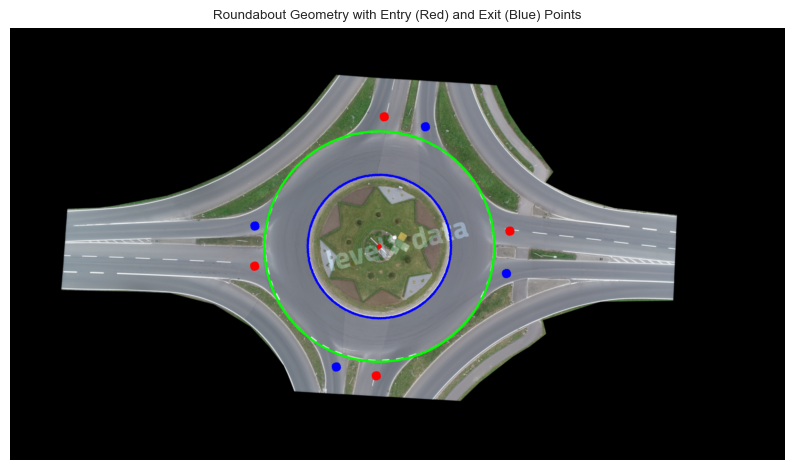

Filtering data with the following parameters:

Sampling period: 400 ms 

Frame spacing: 10 frames 

Rotating data 14.40 degrees counterclockwise to align the roundabout arms with the x-axis.

Roundabout geometry and entry/exit points: 

Roundabout center: (81.18, -47.14) m

Roundabout outer radius: 25.30 m

Roundabout inner radius: 15.75 m

Enntry points: old -> new 

north: (89.40, -19.85) m -> (1.17, 28.48) m

south: (73.47, -74.54) m -> (-0.66, -28.45) m

east: (109.86, -51.06) m -> (28.75, 3.33) m

west: (53.62, -44.59) m -> (-27.33, -4.39) m

Exit points: old -> new 

north: (97.60, -24.22) m -> (10.20, 26.28) m

south: (65.47, -70.50) m -> (-9.41, -26.53) m

east: (106.79, -59.86) m -> (27.97, -5.95) m

west: (55.86, -35.97) m -> (-27.31, 4.53) m

Skipping VRU 0 - Type: bicycle

Skipping VRU 2 - Type: bicycle

Skipping VRU 3 - Type: bicycle

Skipping VRU 7 - Type: bicycle

Number of ego vehicles detected: 565

Total empty groups: 1

Total groups: 565

Groups saved to ./groups_2.json

Ego vehicles saved to ./ego_vehicles_2.json

In [25]:
if os.path.exists("/Users/lmiguelmartinez/Tesis/datasets/rounD/data/"):
    dataset_location = "/Users/lmiguelmartinez/Tesis/datasets/rounD/data/"
else:
    dataset_location = "/home/lmmartinez/Tesis/datasets/rounD/data/"

dataset_index = 2
print("Processing dataset", dataset_index)
scene_data = RounDGroupExtractor(dataset_location=dataset_location, dataset_index=dataset_index)
scene_data.plot_roundabout_geometry_and_points(rotate=True)
scene_data.filter_data(sampling_period=400)

print_blue("Roundabout geometry and entry/exit points:")
print(f"Roundabout center: ({scene_data.center_x_m:.2f}, {scene_data.center_y_m:.2f}) m")
print(f"Roundabout outer radius: {scene_data.outer_radius_m:.2f} m")
print(f"Roundabout inner radius: {scene_data.inner_radius_m:.2f} m")
print_green("Enntry points: old -> new")
for key, point in scene_data.entry_points_m_new.items():
    print(f"{key}: ({scene_data.entry_points_m[key][0]:.2f}, {scene_data.entry_points_m[key][1]:.2f}) m -> ({point[0]:.2f}, {point[1]:.2f}) m")
print_green("Exit points: old -> new")
for key, point in scene_data.exit_points_m_new.items():
    print(f"{key}: ({scene_data.exit_points_m[key][0]:.2f}, {scene_data.exit_points_m[key][1]:.2f}) m -> ({point[0]:.2f}, {point[1]:.2f}) m")

scene_data.get_ego_vehicles(entry_radius=5, exit_radius=10)
scene_data.get_groups()
scene_data.save_groups(save_path="./")
# for dataset_index in range(1, 23):
#     print("Processing dataset", dataset_index)
#     scene_data = RounDGroupExtractor(dataset_location=dataset_location, dataset_index=dataset_index)
#     scene_data.get_roundabout_edges()    
#     scene_data.get_entry_exit_points()
#     scene_data.plot_roundabout_geometry_and_points(rotate=True)
#     scene_data.filter_data(sampling_period=1000)

In [23]:
scene_data.static_info['class'].value_counts()

class
car           602
truck          60
van            39
trailer        17
motorcycle      7
bicycle         4
bus             3
Name: count, dtype: int64